# EZKL Credit Loans



# Step 1: Training a credit score classification model




First, we will need to import all the various dependencies required to train the model

In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

# Define the path to your dataset
file_path = "/content/drive/My Drive/Colab Notebooks/ZKML/CreditScoreClassificationDataset.csv"

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())


   Age  Gender  Income            Education Marital Status  \
0   25  Female   50000    Bachelor's Degree         Single   
1   30    Male  100000      Master's Degree        Married   
2   35  Female   75000            Doctorate        Married   
3   40    Male  125000  High School Diploma         Single   
4   45  Female  100000    Bachelor's Degree        Married   

   Number of Children Home Ownership Credit Score  
0                   0         Rented         High  
1                   2          Owned         High  
2                   1          Owned         High  
3                   0          Owned         High  
4                   3          Owned         High  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 164 non-null    int64 
 1   Gender              164 non-null    object
 2   Income              164 non-null    int64 
 3   Education           164 non-null    object
 4   Marital Status      164 non-null    object
 5   Number of Children  164 non-null    int64 
 6   Home Ownership      164 non-null    object
 7   Credit Score        164 non-null    object
dtypes: int64(3), object(5)
memory usage: 10.4+ KB


In [ ]:
def preprocess_data(df):
    """Encodes categorical variables correctly and ensures numeric data."""

    print("Preprocessing dataset...")

    # **Label Encoding for Ordinal Features**
    label_encoders = {}
    ordinal_cols = ["Education", "Credit Score"]

    for col in ordinal_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # **One-Hot Encoding for Non-Ordinal Features**
    df = pd.get_dummies(df, columns=["Gender", "Marital Status", "Home Ownership"], drop_first=True)

    # 🚨 Fix: Convert all `bool` columns to `int`
    df = df.astype({col: int for col in df.select_dtypes(include=['bool']).columns})

    # **Normalize numerical features**
    scaler = StandardScaler()
    df[["Age", "Income", "Number of Children"]] = scaler.fit_transform(df[["Age", "Income", "Number of Children"]])

    # **Convert everything to numeric to avoid errors**
    df = df.apply(pd.to_numeric, errors="coerce")

    # **Final Debug Check**
    print("✅ Final column data types after encoding:")
    print(df.dtypes)

    # **Split features and target**
    X = df.drop(columns=["Credit Score"])
    y = df["Credit Score"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, label_encoders, scaler

In [ ]:
# Call preprocessing function
train_X, test_X, train_y, test_y, label_encoders, scaler = preprocess_data(df)

Preprocessing dataset...
✅ Final column data types after encoding:
Age                      float64
Income                   float64
Education                  int64
Number of Children       float64
Credit Score               int64
Gender_Male                int64
Marital Status_Single      int64
Home Ownership_Rented      int64
dtype: object


In [ ]:
# iris = load_iris()
# dataset = pd.DataFrame(
#     data= np.c_[iris['data'], iris['target']],
#     columns= iris['feature_names'] + ['target'])
# dataset

Next, we can begin defining the neural net model. For this dataset we will use a small fully connected neural net.

<br />

**Note:**
For the 1st layer we use 4x20, because there are 4 features we want as inputs. After which we add a ReLU.

For the 2nd layer we use 20x20, then add a ReLU.

And for the last layer we use 20x3, because there are 3 classes we want to classify, then add a ReLU.

The last ReLU function gives us an array of 3 elements where the position of the largest value gives us the target that we want to classify.

For example, if we get [0, 0.001, 0.002] as the output of the last ReLU. As, 0.002 is the largest value, the inferred value is 2.



In [ ]:
# class Model(nn.Module):
#     # define nn
#     def __init__(self):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(4, 20)
#         self.fc2 = nn.Linear(20, 20)
#         self.fc3 = nn.Linear(20, 3)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         x = self.relu(x)

#         return x

# # Initialize Model
# model = Model()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 20)  # First hidden layer
        self.fc2 = nn.Linear(20, 20)          # Second hidden layer
        self.fc3 = nn.Linear(20, 3)           # Output layer (assuming 3 credit score categories: Low, Average, High)
        self.relu = nn.ReLU()                 # Activation function

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x  # No activation after last layer since CrossEntropyLoss expects raw logits

# Get the input feature count from preprocessed training data
input_size = train_X.shape[1]

# Initialize model with correct input size
model = Model(input_size)

print(f"✅ Model initialized with input size: {input_size}")


✅ Model initialized with input size: 7


We will now need to split the dataset into a training set and testing set for ML. This is done fairly easily with the `train_test_split` helper function from sklearn.

In [ ]:
# train_X, test_X, train_y, test_y = train_test_split(
#     dataset[dataset.columns[0:4]].values, # use columns 0-4 as X
#     dataset.target, # use target as y
#     test_size=0.2 # use 20% of data for testing
# )


# Uncomment for sanity checks
# print("train_X: ", train_X)
# print("test_X: ", test_X)
print("train_y: ", train_y)
print("test_y: ", test_y)

train_y:  84     1
2      1
94     1
45     1
42     0
      ..
71     1
106    0
14     1
92     1
102    1
Name: Credit Score, Length: 131, dtype: int64
test_y:  135    0
115    1
131    0
55     1
95     1
29     0
157    1
51     1
101    1
145    1
19     0
85     2
15     1
66     1
24     2
30     1
132    1
105    2
152    1
16     1
75     1
18     2
12     2
9      1
31     1
155    1
98     1
56     1
134    1
160    0
139    1
78     1
60     1
Name: Credit Score, dtype: int64


We can now define the parameters for training, we will use the [Cross Entropy Loss](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) and [Stochastic Gradient Descent Optimizer](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In [ ]:
# Convert Pandas DataFrames to PyTorch tensors
# Ensure train_X, test_X, train_y, and test_y are DataFrames before conversion
if not isinstance(train_X, torch.Tensor):
    train_X = torch.tensor(train_X.to_numpy(), dtype=torch.float32)
if not isinstance(test_X, torch.Tensor):
    test_X = torch.tensor(test_X.to_numpy(), dtype=torch.float32)
if not isinstance(train_y, torch.Tensor):
    train_y = torch.tensor(train_y.to_numpy(), dtype=torch.long)
if not isinstance(test_y, torch.Tensor):
    test_y = torch.tensor(test_y.to_numpy(), dtype=torch.long)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move to device
model = Model(input_size).to(device)


# Move tensors to device (Fixed ✅)
train_X = train_X.to(device)
test_X = test_X.to(device)
train_y = train_y.to(device)
test_y = test_y.to(device)

print("✅ Model and data successfully moved to:", device)



✅ Model and data successfully moved to: cpu


In [ ]:
# our loss function
loss_fn = nn.CrossEntropyLoss()

# our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


# use 800 EPOCHS
EPOCHS = 800




loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))


# we use tqdm for nice loading bars
for epoch in tqdm.trange(EPOCHS):

    # To train, we get a prediction from the current network
    predicted_y = model(train_X)

    # Compute the loss to see how bad or good we are doing
    loss = loss_fn(predicted_y, train_y)

    # Append the loss to keep track of our performance
    loss_list[epoch] = loss.item()

    # Afterwards, we will need to zero the gradients to reset
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate the accuracy, call torch.no_grad() to prevent updating gradients
    # while calculating accuracy
    with torch.no_grad():
        y_pred = model(test_X)
        correct = (torch.argmax(y_pred, dim=1) == test_y).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 800/800 [00:01<00:00, 597.53it/s]


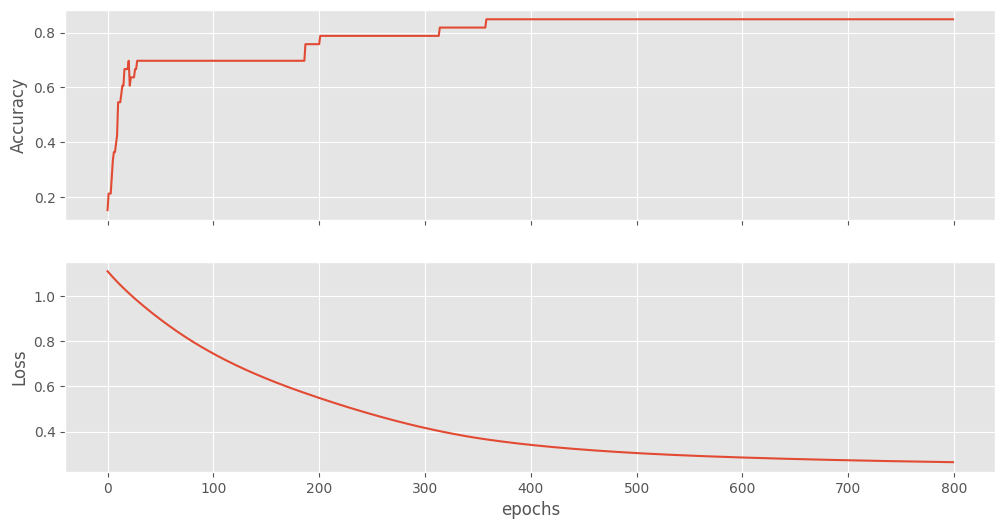

In [ ]:
# Plot the Accuracy and Loss

# import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')


fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("Accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("Loss")
ax2.set_xlabel("epochs");

## Congratulations! You've just trained a neural network

**Exercise:** The model provided is very simplistic, what are other ways the model can be improved upon?

In [ ]:
# import torch
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# def predictions(model, test_X, test_y):
#     """
#     Evaluates the trained model on the test dataset and prints accuracy, precision, recall, and F1 score.
#     """

#     print("\n🔍 Evaluating Model on Test Data...")

#     # Put model in evaluation mode
#     model.eval()

#     # Move test data to the same device as model (important for GPU training)
#     test_X = test_X.to(model.fc1.weight.device)
#     test_y = test_y.to(model.fc1.weight.device)

#     # Disable gradient computation during testing (saves memory)
#     with torch.no_grad():
#         y_pred_logits = model(test_X)  # Get raw logits
#         y_pred = torch.argmax(y_pred_logits, dim=1)  # Convert to class predictions

#     # Compute accuracy
#     correct = (y_pred == test_y).sum().item()
#     total = test_y.size(0)
#     test_accuracy = correct / total

#     print(f"🔹 Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

#     # Convert tensors to NumPy for sklearn metrics
#     y_pred_np = y_pred.cpu().numpy()
#     test_y_np = test_y.cpu().numpy()

#     # Compute precision, recall, and F1-score
#     test_acc = accuracy_score(test_y_np, y_pred_np)
#     test_precision = precision_score(test_y_np, y_pred_np, average='weighted')
#     test_recall = recall_score(test_y_np, y_pred_np, average='weighted')
#     test_f1 = f1_score(test_y_np, y_pred_np, average='weighted')

#     print(f"🔹 Precision: {test_precision:.4f}")
#     print(f"🔹 Recall: {test_recall:.4f}")
#     print(f"🔹 F1 Score: {test_f1:.4f}")

#     return test_acc, test_precision, test_recall, test_f1


In [ ]:
import pandas as pd
import torch

def predictions(model, test_X, test_y, df, scaler, label_encoders):
    """
    Evaluates the model on test data and displays predictions in real-world values.
    """

    print("\n🔍 Evaluating Model on Test Data...")

    # Put model in evaluation mode
    model.eval()

    # Move test data to the same device as model
    test_X = test_X.to(model.fc1.weight.device)
    test_y = test_y.to(model.fc1.weight.device)

    # Disable gradient computation during testing (saves memory)
    with torch.no_grad():
        y_pred_logits = model(test_X)  # Get raw logits
        y_pred = torch.argmax(y_pred_logits, dim=1)  # Convert to class labels

    # Convert tensors to NumPy
    y_pred_np = y_pred.cpu().numpy()
    test_y_np = test_y.cpu().numpy()
    test_X_np = test_X.cpu().numpy()

    # Reverse standardization for numerical features
    original_features = scaler.inverse_transform(test_X_np[:, :3])  # Only first 3 columns were scaled

    # Convert predictions back to original category labels
    # credit_score_labels = {v: k for k, v in label_encoders["Credit Score"].classes_.items()}  # Reverse mapping
    credit_score_labels = {v: k for v, k in enumerate(label_encoders["Credit Score"].classes_)}


    # Reconstruct DataFrame with original values
    results_df = pd.DataFrame(original_features, columns=["Age", "Income", "Number of Children"])

    # Add categorical features back (Gender, Marital Status, etc.)
    original_categorical = pd.DataFrame(test_X_np[:, 3:], columns=[col for col in df.columns if col not in ["Age", "Income", "Number of Children", "Credit Score"]])

    # Add decoded predictions
    results_df = pd.concat([results_df, original_categorical], axis=1)
    results_df["Predicted Credit Score"] = [credit_score_labels[val] for val in y_pred_np]
    results_df["Actual Credit Score"] = [credit_score_labels[val] for val in test_y_np]

    print("\n🔹 Sample of Real-World Predictions:")
    print(results_df.head(10))  # Show first 10 rows

    return results_df  # Return the full DataFrame if needed


In [ ]:
# predictions(model, test_X, test_y)

In [ ]:
results_df = predictions(model, test_X, test_y, df, scaler, label_encoders)



🔍 Evaluating Model on Test Data...

🔹 Sample of Real-World Predictions:
    Age   Income  Number of Children    Gender  Education  Marital Status  \
0  25.0  55000.0            1.533088 -0.740862        0.0             1.0   
1  48.0  87500.0            2.413737  0.394665        0.0             0.0   
2  26.0  55000.0            1.533088  0.394665        0.0             0.0   
3  39.0  62500.0            1.533088  1.530191        0.0             0.0   
4  35.0  90000.0            2.413737  0.394665        0.0             0.0   
5  25.0  55000.0            1.533088 -0.740862        0.0             1.0   
6  48.0  82500.0            2.413737  0.394665        0.0             0.0   
7  48.0  82500.0            2.413737  0.394665        0.0             0.0   
8  36.0  95000.0            4.175035  1.530191        0.0             0.0   
9  46.0  95000.0            3.294386  0.394665        0.0             0.0   

   Home Ownership Predicted Credit Score Actual Credit Score  
0             1.

# Step 2: ZK the Neural Network

Now that we have the Neural Network trained, we can use ezkl to easily ZK our model.

To proceed we will now need to install `ezkl`



In [ ]:
# check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import os
import json
import ezkl

Next, we will need to export the neural network to a `.onnx` file. ezkl reads this `.onnx` file and converts it into a circuit which then allows you to generate proofs as well as verify proofs

In [ ]:
# Specify all the files we need

model_path = os.path.join('network.onnx')
data_path = os.path.join('input.json')
cal_data_path = os.path.join('calibration.json')

In [ ]:
# After training, export to onnx (network.onnx) and create a data file (input.json)

# create a random input
# x = test_X[0].reshape(1, 4)


# Get the actual number of features dynamically
num_features = test_X.shape[1]  # Should be 7

# Reshape correctly
x = test_X[0].reshape(1, num_features)

# Flips the neural net into inference mode
model.eval()

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  model_path,                # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

    # Serialize data into file:
json.dump(data, open(data_path, 'w'))





After which we can proceed to generate the settings file for `ezkl` and run calibrate settings to find the optimal settings for `ezkl`

In [ ]:
!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings()
assert res == True



In [ ]:
# use the test set to calibrate the circuit
cal_data = dict(input_data = test_X.flatten().tolist())

# Serialize calibration data into file:
json.dump(data, open(cal_data_path, 'w'))

# Optimize for resources, we cap logrows at 12 to reduce setup and proving time, at the expense of accuracy
# You may want to increase the max logrows if accuracy is a concern
res = await ezkl.calibrate_settings(target = "resources", max_logrows = 12, scales = [2])


 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+-------------+--------------+------------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error  | median_error | max_error  | min_error   | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+-------------+--------------+------------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| -0.16247822 | -0.275648    | 0.18825907 | -0.40004575 | 0.28798428     | 0.275648         | 0.40004575    | 0.18825907    | 0.09048664         | 0.19201834         | 0.35131922             |
+-------------+--------------+------------+-------------+----------------+------------------+---------------

Next, we will compile the model. The compilation step allow us to generate proofs faster.

In [ ]:
res = ezkl.compile_circuit()
assert res == True

Before we can setup the circuit params, we need a SRS (Structured Reference String). The SRS is used to generate the proofs.

In [ ]:
res = await ezkl.get_srs()

Now run setup, this will generate a proving key (pk) and verification key (vk). The proving key is used for proving while the verification key is used for verificaton.

In [ ]:
res = ezkl.setup()


assert res == True

Now, we can generate a proof and verify the proof as a sanity check. We will use the "evm" transcript. This will allow us to provide proofs to the EVM.

In [ ]:
# Generate the Witness for the proof

# now generate the witness file
witness_path = os.path.join('witness.json')

res = await ezkl.gen_witness()
assert os.path.isfile(witness_path)

In [ ]:
# Generate the proof

proof_path = os.path.join('proof.json')

proof = ezkl.prove(proof_type="single", proof_path=proof_path)

print(proof)
assert os.path.isfile(proof_path)

{'instances': [['1302000000000000000000000000000000000000000000000000000000000000', '63ffffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '2f00000000000000000000000000000000000000000000000000000000000000']], 'proof': '0x14a41f0df048eebcfce32075110840ac4d05854e0ccd3fa9dd03447007a28e9a2072b6e140dc97d892ede69ffb58a6353de96c8eade373d78db9651561f05e5f302b6a781be7de42d0eb5b96e3c16431c47441b20b257fa22c1ae348e46f2caa17021cc013d19551e5cebb7c71493ec946deea1ce18f64783e0741cb21a2ad5214de530fed71d4d4d0e9f1b97520b2b804b411fa712033ad2638be2836e67c6f1df5a3051a8f404e2db89d0a86c4ba2856571afd9d2d37b749314e1b719401b801bc61fd41b0ad746940b73506c44ab2f4147827036b6a47d62d9fc5c3558e3908266ee8ed571fadcda4b41f10297e2848299c635ba93c5b5562397c59f98eaf0be9e694b766cfaf64e2e4c70b1058906eec1a4d83b5e50c16e6648b4607be6c01a69d34539cc4a6eb695c584c820f5c48b59e25a5928d81ea2f43b4a19029bb00a79a17d9d2fec665a3f883fb4f454f480eaea74025e36285f89fc66d2261f906d5d15ab320d188e3047265e209e8282b7748ae390478dacedbaee5cbe7f4

In [ ]:
# verify our proof

res = ezkl.verify()

assert res == True
print("verified")

verified


## Congratulations! You have just turned your Neural Network into a Halo2 Circuit!



# Part 3: Deploying the Verifier
Now that we have the circuit setup, we can proceed to deploy the verifier onchain.

We will need to setup `solc=0.8.20` for this.

In [ ]:
# check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "solc-select"])
    !solc-select install 0.8.20
    !solc-select use 0.8.20
    !solc --version

# rely on local installation if the notebook is not in colab
except:
    pass

Installing solc '0.8.20'...
Version '0.8.20' installed.
Switched global version to 0.8.20
solc, the solidity compiler commandline interface
Version: 0.8.20+commit.a1b79de6.Linux.g++


With solc in our environment we can now create the evm verifier.

In [ ]:
sol_code_path = os.path.join('Verifier.sol')
abi_path = os.path.join('Verifier.abi')

res = await ezkl.create_evm_verifier(
        sol_code_path=sol_code_path,
        abi_path=abi_path,
    )

assert res == True
assert os.path.isfile(sol_code_path)

In [ ]:
onchain_input_array = []

# using a loop
# avoiding printing last comma
formatted_output = "["
for i, value in enumerate(proof["instances"]):
    for j, field_element in enumerate(value):
        onchain_input_array.append(ezkl.felt_to_big_endian(field_element))
        formatted_output += '"' + str(onchain_input_array[-1]) + '"'
        if j != len(value) - 1:
            formatted_output += ", "
    if i != len(proof["instances"]) - 1:
        formatted_output += ", "
formatted_output += "]"

# This will be the values you use onchain
# copy them over to remix and see if they verify
# What happens when you change a value?
print("pubInputs: ", formatted_output)
print("proof: ", proof["proof"])

pubInputs:  ["0x0000000000000000000000000000000000000000000000000000000000000213", "0x30644e72e131a029b85045b68181585d2833e84879b9709143e1f593efffff63", "0x000000000000000000000000000000000000000000000000000000000000002f"]
proof:  0x14a41f0df048eebcfce32075110840ac4d05854e0ccd3fa9dd03447007a28e9a2072b6e140dc97d892ede69ffb58a6353de96c8eade373d78db9651561f05e5f302b6a781be7de42d0eb5b96e3c16431c47441b20b257fa22c1ae348e46f2caa17021cc013d19551e5cebb7c71493ec946deea1ce18f64783e0741cb21a2ad5214de530fed71d4d4d0e9f1b97520b2b804b411fa712033ad2638be2836e67c6f1df5a3051a8f404e2db89d0a86c4ba2856571afd9d2d37b749314e1b719401b801bc61fd41b0ad746940b73506c44ab2f4147827036b6a47d62d9fc5c3558e3908266ee8ed571fadcda4b41f10297e2848299c635ba93c5b5562397c59f98eaf0be9e694b766cfaf64e2e4c70b1058906eec1a4d83b5e50c16e6648b4607be6c01a69d34539cc4a6eb695c584c820f5c48b59e25a5928d81ea2f43b4a19029bb00a79a17d9d2fec665a3f883fb4f454f480eaea74025e36285f89fc66d2261f906d5d15ab320d188e3047265e209e8282b7748ae390478dacedbaee5cbe7f45

We will exit colab for the next steps. At the left of colab you can see a folder icon. Click on that.


You should see a `Verifier.sol`. Right-click and save it locally.

Now go to [https://remix.ethereum.org](https://remix.ethereum.org).

Create a new file within remix and copy the verifier code over.

Finally, compile the code and deploy. For the demo you can deploy to the test environment within remix.

If everything works, you would have deployed your verifer onchain! Copy the values in the cell above to the respective fields to test if the verifier is working.

**Note that right now this setup accepts random values!**

This might not be great for some applications. For that we will want to use a data attested verifier instead. [See this tutorial.](https://github.com/zkonduit/ezkl/blob/main/examples/notebooks/data_attest.ipynb)

## Congratulations for making it this far!

If you have followed the whole tutorial, you would have deployed a neural network inference model onchain! That's no mean feat!